<a href="https://colab.research.google.com/github/DariusStaugas/rag-from-scratch-colab/blob/main/RAG_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Library, drive and hugginface setup

In [2]:
#Log into huggingface
!huggingface-cli login

#Mount Google drive. I store all related files there
from google.colab import drive
drive.mount('/content/drive')

#Libraries
!pip install -U PyMuPDF
!pip install -U spacy
!pip install -U scikit-learn
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U sentence-transformers
!pip install -U transformers==4.38.2
!pip install -U bitsandbytes
!pip install -U accelerate



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).

##Declare Global variables and do imports

In [31]:
#Global variables

#Assumes you have created a folder called RAG_project in your Google drive root directory

SMALL_VRAM = True #For gemma-7b anything bellow 18-20GB is too small.
                  #This should be set to True if that is the case
LOW_CPU_MEM_USAGE = True #Makes loading a bit slower, but possible in low RAM (not VRAM)
                        # environments. Does nothing when using CPU to load the LLM model

#Change these deppending on setup
PROJECT_LOCATION = '/content/drive/MyDrive/RAG_project'
PDF_LOCATION = PROJECT_LOCATION + '/human-nutrition-text.pdf'
EMBEDDINGS_DF_SAVE_PATH = '/content/drive/MyDrive/RAG_project/text_chunks_and_embeddings_df.csv'
GENERAL_INFO_DF_SAVE_PATH = '/content/drive/MyDrive/RAG_project/general_info_df.csv'

EMBEEDING_MODEL_ID = "all-mpnet-base-v2"
EMBEDDING_MODEL_DEVICE = "cuda"
EMBEDDING_BATCH_SIZE = 64

LLM_DEVICE='cuda' #'cpu' or 'cuda'
LLM_TOKENIZER_DEVICE = LLM_DEVICE # Tokenized input should be in the same place as LLM
LLM_MODEL_ID = "google/gemma-7b-it" #or something else, like"google/gemma-7b-it"
LLM_TEMPERATURE = 0.7 #from 0 to 1. Lower - deterministic, higher - creative outputs
MAX_NEW_TOKENS_IN_OUTPUT = 256 #Determines the maximum amount of new tokens in the LLM output
MODEL_START_OF_TURN_TOKEN = "<start_of_turn>model" #By default model output of LLM include the input. This denotes where the output of the model starts

FIRST_PAGE_NUMBER = 41 # A lot of book type PDFs will start counting pages not from the start,
                        # but rather from some further page. I.e. in human-nutrition-text.pdf it starts
                        # on page 41

#One context item is just a chunk of n sentences from the pdf. The n is defined here
#Bigger chunks = more information passed to the LLM with every context entry
SENTENCES_CHUNK_SIZE = 10

#Small chunks might not be very informative. They are removed if num of tokens is lower than this
MIN_CHUNK_LENGTH_IN_TOKENS = 30

#If True, displays some extra info when doin input of ouput
VERBOSE_MODE = False


In [4]:
from spacy.lang.en import English
import pandas as pd
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import numpy as np
import torch
import fitz
from tqdm.auto import tqdm
import random
import ast
from time import perf_counter as timer
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig

import re

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Utils functions


In [5]:
# Free up memory after using the model (not sure if works completely correctly in colab)
def free_model_memory(model):
    del model  # Delete the model object
    if (EMBEDDING_MODEL_DEVICE == 'cuda'):
       torch.cuda.empty_cache()  # Clear the CUDA cache if using GPU
    model = None  # Ensure model is not referenced anymore

In [6]:
#Calculate number of pramaters in LLM
def get_model_num_params(model: torch.nn.Module):
  print(f'Number of params in this LLM: {sum([param.numel() for param in model.parameters()])}')

In [7]:
# Calculate how much memory it takes up
def get_model_mem_size(model: torch.nn.Module):
  #Get model parameters and buffer sizes
  mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
  mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
  total_mem_gb = round((mem_params + mem_buffers)/(1024**3), 2)
  print(f'Memory taken up in GB: {total_mem_gb}')

##Format the pdf and turn it into embeddings. Save embeds to google drive

In [8]:
#Helper function. Performs minor formatting on text. Specific to human-nutrition-text.pdf
def text_formatter(text: str) -> str:
  cleaned_text = text.replace("\n", " ").strip()
  return cleaned_text

#Open the pdf and start extracting information from it into a list[dict]
def open_and_read_pdf(pdf_path: str) -> list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_text = []
  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text=text)
    pages_and_text.append({"page_number": page_number - FIRST_PAGE_NUMBER, #Specific to the file, current one starts counting pages from page 42
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(". ")),
                            "page_token_count": len(text)/ 4,  #One token is roughly four characters
                            "text": text})
  return pages_and_text

In [9]:
#Further text pre-processing
# Split text into smaller chunks - sentences
# You can split sentences by splitting on ". "
# But here an actual library will be used. spaCy
def pages_and_text_to_sentences(pages_and_text: list[dict]):
  nlp = English()

  # Add a sentencizer pipeline. It basiccally turns text into sentences.
  nlp.add_pipe("sentencizer")

  # Sentencize the text
  for entry in tqdm(pages_and_text):
    #Create a new field "sentences" which has a list of sentences n the text
    entry["sentences"] = list(nlp(entry["text"]).sents)

    #Convert to strings (the default type is a spaCy Span datatype)
    entry["sentences"] = [str(sentence) for sentence in entry["sentences"]] #Very little code ♥

    # Count the sentences
    entry["page_sentence_count_spacy"] = len(entry['sentences'])

In [10]:
# Chunk sentences together. For this one, let's try groups of SENTENCES_CHUNK_SIZE.
# We can use a library, like Langchain TextSplitters, to do this
# But we will use pure python

def chunkify_sentences (pages_and_text: list[dict]):
  for entry in tqdm(pages_and_text):
    #Split the text from each entry (entry is a page of pdf here), that has been sentencized, into chunks
    entry["sentence_chunks"] = [entry["sentences"][i:i+SENTENCES_CHUNK_SIZE] for i in range (0, len(entry["sentences"]), SENTENCES_CHUNK_SIZE)]
    #New field for the number of chunks
    entry['num_chunks'] = len(entry["sentence_chunks"])


In [11]:
#Does some formating on each sentence chunk

def format_chunks_and_put_to_separate_dict (pages_and_text: list[dict]) -> list[dict]:
  pages_and_chunks = []
  for entry in tqdm(pages_and_text):
    for sent_chunk in entry['sentence_chunks']:
      chunk_dict = {}
      chunk_dict['page_number'] = entry['page_number']
      # Now join lists of 10 sentences into paragraphs of 10 sentences. Basically merge into 1 string
      joined_sentence_chunk= "".join(sent_chunk)
      joined_sentence_chunk = joined_sentence_chunk.replace("  ", " ").strip() #More pre-processing for this particular file
      joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) #Changes ".A" => ". A"
      chunk_dict["sentence_chunk"] = joined_sentence_chunk

      #Some stats
      chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
      chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
      chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 #Approximate, assuming 4 char ~= 1 token

      pages_and_chunks.append(chunk_dict)
  return pages_and_chunks

In [12]:
#Small chunks might not be very informative. Remove them

def remove_small_chunks (pages_and_chunks: list[dict]):
  pages_and_chunks = [entry for entry in pages_and_chunks if entry["chunk_token_count"] > MIN_CHUNK_LENGTH_IN_TOKENS]

In [13]:
#Function that actually turns text into embeddings
def embed_chunks (pages_and_chunks: list[dict],
                  embedding_model):
  #Get all chunks into separate list
  text_chunks = [item["sentence_chunk"] for item in pages_and_chunks]

  #Create embeddings
  text_chunk_embeddings = embedding_model.encode(text_chunks,
                                                batch_size=EMBEDDING_BATCH_SIZE #VRAM dependant
                                                )

  for entry, embedding in zip(pages_and_chunks, text_chunk_embeddings):
    print("AAAA")
    entry['embeddings'] = list(embedding) ##Importnat: how to turn ndarray into a list I can add to pandas df


In [14]:
#Saves files to specified location (in this case Google Drive)
def save_files(pages_and_text: list[dict],
               pages_and_chunks: list[dict]):
  pd.DataFrame(pages_and_text).to_csv(GENERAL_INFO_DF_SAVE_PATH, index=False)
  pd.DataFrame(pages_and_chunks).to_csv(EMBEDDINGS_DF_SAVE_PATH, index=False)

In [15]:
#Start putting it all together
def read_and_format_pdf() -> tuple[list[dict], list[dict]]:
  pages_and_text = open_and_read_pdf(PDF_LOCATION)
  pages_and_text_to_sentences(pages_and_text)
  chunkify_sentences(pages_and_text)
  pages_and_chunks = format_chunks_and_put_to_separate_dict(pages_and_text)
  remove_small_chunks(pages_and_chunks)
  return pages_and_text, pages_and_chunks

In [16]:
#And now put it all together

#Load and format text. Put all info about it into list[dict]
pages_and_text, pages_and_chunks = read_and_format_pdf()

#Load the embedding model
embedding_model = SentenceTransformer(model_name_or_path=EMBEEDING_MODEL_ID,
                                      device=EMBEDDING_MODEL_DEVICE)

#Embed the chunks
embed_chunks(pages_and_chunks=pages_and_chunks,
             embedding_model=embedding_model)

#Save the information to CSVs
save_files(pages_and_text=pages_and_text,
           pages_and_chunks=pages_and_chunks)

#Try to free up memory (not sure if works completely on Colab)
free_model_memory(embedding_model)

0it [00:00, ?it/s]

  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/1208 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA


## Setup LLM model and RAG

In [17]:
def extract_and_format_embeddings_from_df(df: pd.DataFrame,
                                          device: str):
  # In this particular implementation, after we export data to csv in the previous step the embeddings get turned into string
  # When we import them back, we want them to be an ndarray again, so we can do mathematic operations on it
  embeddings = text_chunks_and_embedding_df['embeddings'].apply(lambda x: np.array(ast.literal_eval(x)))
  # Convert embeddings to torch tensor, send to device and return them as an object
  # (note: NumPy arrays are float64, torch tensors are float32 by default)
  return torch.tensor(np.array(embeddings.tolist()), dtype=torch.float32).to(device)

In [18]:
# To do RAG we need to be able to retrieve relevant resources
# Here we input the desired query and all of our embeddings and see
#  which chunk of text is the most relevant to the quesry
def retrieve_relevant_resources(query: str,
                                embeddings: torch.Tensor
                                ) -> tuple[torch.Tensor, torch.Tensor]:
  # Print query for display purposes
  print(f"Query is: {query}")

  #Embed it
  q_embedding = embedding_model.encode(query, convert_to_tensor=True)

  #Get similarity score with dot product (or use cosine similarity if the output is not normalised) ((WHYYYY??))
  start_time = timer() #This tracks how long the search takes
  dot_scores = util.dot_score(a=q_embedding, b=embeddings)[0]
  if VERBOSE_MODE: print(f"[INFO] The dot scores are: {dot_scores}")
  end_time = timer()
  #Display the time taken
  if VERBOSE_MODE: print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

  # Get the top-k results (for now top 5)
  top_results_dot_prod = torch.topk(dot_scores, k=5)
  return top_results_dot_prod[0], top_results_dot_prod[1]

#NOTE ON RERANKING
# We can potentially improve the results by reranking the top k results
# Reranking is basically taking the top k entries chosen via our similarity search,
#  then we feed them, along with the initial prompt to another AI model.
#  That AI model is specialised in reranking. It basically looks at the k entries
#  that are chosen via similarity search and potentially changes their order based
#  on it's own measure of similarity.

In [19]:
# When loading a model there are a few parameters to consider
#   One of them: A quantization config (optional) - a config on what precision to load the model
#    in (4/8/16/32 bit). There is always a default, usually based on the model itself.
#    We can try loading at lower precision for less memory ocupied.
#    Loading at higher than default gives no benefits.

def load_LLM_model() -> tuple[torch.nn.Module, torch.nn.Module]:

  #Creating a quantization config with BitsAndBytes. In case we decide to run on weak GPU
  #quant_config = BitsAndBytesConfig(load_in_8bit=True) #Might want to adjust this at some point
  quant_config = BitsAndBytesConfig(load_in_4bit = True,
                                    bnb_4bit_compute_dtype=torch.float16)

  #There is a lot of tricks to make LLM run/load faster
  #I.e. Using FlashAttention. Messes with the attection mechanism in LLMs.
  # FlashAttention is only possible on certain GPUs
  #Bellow line shows if such technique is available on your current gpu
  from transformers.utils import is_flash_attn_2_available
  if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0]) >= 8:
    attn_implementation = "flash_attention_2"
  else:
    attn_implementation = "sdpa" #Scaled dot product attention

  # Istantiate the model
  llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path = LLM_MODEL_ID,
                                                  torch_dtype = torch.float16,
                                                  quantization_config = quant_config if (SMALL_VRAM and LLM_DEVICE == "cuda") else None,
                                                  low_cpu_mem_usage=LOW_CPU_MEM_USAGE, #If in low RAM (not VRAM) enviroment, then true. This is because model first loads into RAM then VRAM.
                                                  attn_implementation=attn_implementation)
  if not SMALL_VRAM or LLM_DEVICE == "cpu": #BitsAndBytesConfig seems to automatically send to gpu if it is used (and gpu available)
    llm_model.to(LLM_DEVICE)

  #Load tokenizer as well
  llm_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = LLM_MODEL_ID)

  return llm_model, llm_tokenizer

In [20]:
#AUGMENTING INPUT WITH DATA FROM THE PDF
#This creates a prompt that has the original query and the context from the pdf
def make_prompt(query: str,
                indices: torch.Tensor,
                text_chunks_and_embedding_df: pd.DataFrame) -> str:
  #Fetches best context items, based on the indices provided
  context_items= [text_chunks_and_embedding_df.iloc[index] for index in indices.tolist()] #TODO: verify this is correct
  #Takes the text chunks and puts them all in one string
  context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
  #And finally puts them in a formatted promt
  #TODO: check if this prompt can be improved
  new_prompt = f"Based on the following contexts:\n {context}\n Please answer the following query: \n{query}"
  return new_prompt

In [41]:
#GENERATING ANSWER TO PROMPT WITH A LOADED MODEL
def get_output(prompt: str,
               llm_model: torch.nn.Module,
               llm_tokenizer: torch.nn.Module) -> str:
  # Some (or most) LLM models were trained using a specific input template
  # This means, all data has been fed to them in a very specific manner
  # We don't necesearrily have to follow the same template they have used for training, BUT
  #  it is HIGHLY advised if we want good results
  # Bellow code forms a template specific to gemma-7b-it model.
  # Might need to change it with another model
  chat = [{
    "role": "user",
    "content": prompt
  }]
  #Applies the template specified above
  prompt = llm_tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

  #We can't feed text to the LLM. Need to turn the prompt to embeddings.
  #Note: we are using a model specific tokenizer here. Not the one we used while processing the PDF originally
  tokenized_prompt = llm_tokenizer(prompt, return_tensors="pt").to(LLM_TOKENIZER_DEVICE) #TODO: investigate attention masks
  outputs = llm_model.generate(**tokenized_prompt, # ** unpacks the tokenize_prompts list. Effectively the same sa putting in (tokenized_prompt["input_ids"], tokenized_prompt["attention_masks"])
                              temperature=LLM_TEMPERATURE,
                               do_sample=True,
                              max_new_tokens=MAX_NEW_TOKENS_IN_OUTPUT)
  return llm_tokenizer.decode(outputs[0]) #Originally outputs are returned in embeddings

In [22]:
#Load data
text_chunks_and_embedding_df = pd.read_csv(EMBEDDINGS_DF_SAVE_PATH)
embeddings = extract_and_format_embeddings_from_df(text_chunks_and_embedding_df, device=EMBEDDING_MODEL_DEVICE)

#Load the embedding model used to transform the data extracted from the PDF
embedding_model = SentenceTransformer(model_name_or_path=EMBEEDING_MODEL_ID,
                                      device=EMBEDDING_MODEL_DEVICE)

#Load the LLM model and the tokenizer
llm_model, llm_tokenizer = load_LLM_model()

#Get info about model
#get_model_num_params(llm_model)
#get_model_mem_size(llm_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

## Setup functions for querying and displaying result

In [36]:
#Function to display the actual page where the information is being taken from
# Only displays one page, that has the best score
def show_correct_page(page_index: int,
                      text_chunks_and_embedding_df: pd.DataFrame,
                      query: str):
  doc = fitz.open(PDF_LOCATION)
  correct_page = text_chunks_and_embedding_df.loc[page_index]["page_number"] #Takes index of the highest scoring page. Assumes first is the highest
  page = doc.load_page(correct_page.item()+FIRST_PAGE_NUMBER) ##Acount for the unnumerated pages

  #Another fitz fuction. Gets an image representation of the page
  img = page.get_pixmap(dpi=300)

  #Save the image (optional)
  #img.save("output_filename.png")

  #Convert pixmap toa numpy array so we can feed it to matplotlib
  img_array = np.frombuffer(img.samples_mv,
                            dtype=np.uint8).reshape((img.h, img.w, img.n))

  #Display the image using Matplotlib
  plt.figure(figsize=(13, 10))
  plt.imshow(img_array)
  plt.title(f"Query: '{query}'  |  Most relevant page:")
  plt.axis("off")
  plt.show()


In [37]:
def trim_output(output: str) -> str:
  eos_index= output.find(MODEL_START_OF_TURN_TOKEN)
  if eos_index != -1:
    return output[eos_index + len(MODEL_START_OF_TURN_TOKEN):]
  else:
    return f" ERROR: Your MODEL_START_OF_TURN_TOKEN {MODEL_START_OF_TURN_TOKEN} was not found in the provided output: {output}. Please check the global variable, or set show_full_input to True"

In [38]:

def query_the_model(show_full_input: bool):

  #Get the query
  query=input("Please enter your query \n")
  print("\nModel is thinking....\n")

  #Get indices of the most relevant contexts.
  best_context_scores, best_context_indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

  #Constructs the input prompt and gets the output
  prompt = make_prompt(query=query, indices=best_context_indices, text_chunks_and_embedding_df=text_chunks_and_embedding_df)

  #And finally get the output from the LLM (TODO: format this to make it prettier?)
  output = get_output(prompt=prompt, llm_model=llm_model, llm_tokenizer=llm_tokenizer)

  print(output if show_full_input else trim_output(output))

  #Display the page with the best context
  show_correct_page(page_index=best_context_indices[0].item(), text_chunks_and_embedding_df=text_chunks_and_embedding_df, query=query)


##Use the whole setup (opens up an input window)

Please enter your query 
What is fat?

Model is thinking....

Query is: What is fat?

Sure, here is the answer to the query:

Fat tissue is a complex tissue composed of adipocytes, which are specialized cells for storing energy in the form of triglycerides. It plays a crucial role in regulating energy balance by storing excess energy from the diet and releasing it when energy is needed. Fat tissue also contributes to satiety, the sensation of fullness, and plays a role in regulating food intake by producing hormones and inflammatory factors.<eos>


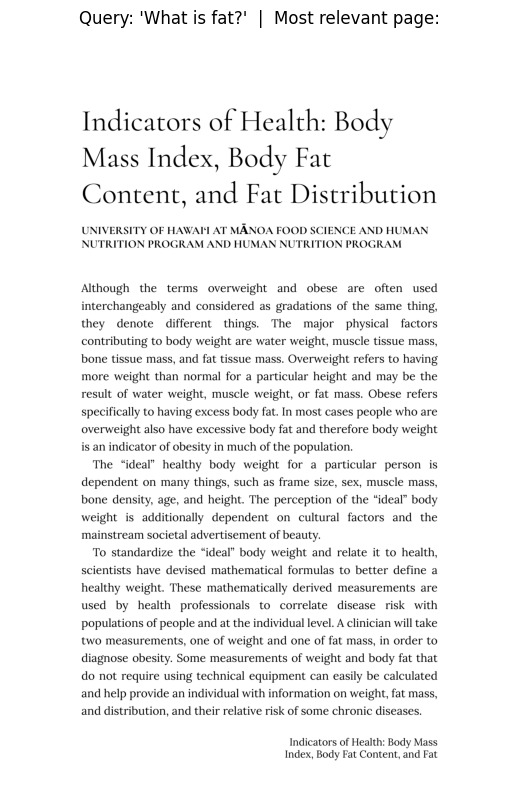

In [42]:
query_the_model(show_full_input=False)

##Clear VRAM (TODO: finish)



In [ ]:
import gc
free_model_memory(llm_model)
gc.collect()

0

##Extensions

Investigate better loading of LLM https://huggingface.co/docs/accelerate/v0.25.0/en/concept_guides/big_model_inference

May want to improve text extraction with something like Marker - https://github.com/VikParuchuri/marker

Guide to more advanced PDF extraction - https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517

See the following prompt engineering resources for more prompting techniques - promptinguide.ai, Brex's Prompt Engineering Guide


What happens when a query comes through that there isn't any context in the textbook on?

Try another embedding model (e.g. Mixed Bread AI large, mixedbread-ai/mxbai-embed-large-v1, see: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

Try another LLM... (e.g. Mistral-Instruct)

Try different prompts (e.g. see prompting techniques online)

Our example only focuses on text from a PDF, however, we could extend it to include figures and images
Evaluate the answers -> could use another LLM to rate our answers (e.g. use GPT-4 to make)

Vector database/index for larger setup (e.g. 100,000+ chunks)

Libraries/frameworks such as LangChain / LlamaIndex can help do many of the steps for you - so it's worth looking into those next, wanted to recreate a workflow with lower-level tools to show the principles
Optimizations for speed

See Hugging Face docs for recommended speed ups on GPU - https://huggingface.co/docs/transformers/perf_infer_gpu_one

Optimum NVIDIA - https://huggingface.co/blog/optimum-nvidia, GitHub: https://github.com/huggingface/optimum-nvidia

See NVIDIA TensorRT-LLM - https://github.com/NVIDIA/TensorRT-LLM

See GPT-Fast for PyTorch-based optimizations - https://github.com/pytorch-labs/gpt-fast

Flash attention 2 (requires Ampere GPUs or newer) - https://github.com/Dao-AILab/flash-attention

Stream text output so it looks prettier (e.g. each token appears as it gets output from the model)

Turn the workflow into an app, see Gradio type chatbots for this - https://www.gradio.app/guides/creating-a-chatbot-fast, see local example: https://www.gradio.app/guides/creating-a-chatbot-fast#example-using-a-local-open-source-llm-with-hugging-face


